In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import pandas as pd
import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference

from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob
# from pyproj import Proj

from scipy.optimize import curve_fit


In [2]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")
n = 1.4682
L = 51.04762

b=0
for q in np.arange(2,7):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))

# working_dat = np.load(file_list[15])
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat#[:,::10]
working_dat = working_dat *10**6#/(np.std(working_dat))
working_dat = working_dat[:,::10].T
mean_remove = (working_dat - np.mean(working_dat,axis=0)).T

working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)


In [3]:
working_dat.shape

(5000, 6000, 1)

In [4]:
dt=1. #/200
xs = np.arange(working_dat.shape[0]) #2.0419047*np.arange(working_dat.shape[0])
# time = dt*np.arange(working_dat.shape[0])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=xs,
    include_bias=True,
    is_uniform=True,
#     periodic=True
)

### Init Model

In [5]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [6]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.5
(x0)' = 0.593 x0_1


In [8]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [9]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.05
(x0)' = 0.637 x0_1 + 30.817 x0_111 + -0.113 x0x0x0_111


In [10]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)



In [11]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.005
(x0)' = 0.642 x0_1 + 0.026 x0_11 + 31.663 x0_111 + -0.017 x0x0x0_1 + -0.019 x0x0x0_11 + -2.766 x0x0x0_111


In [12]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [13]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.5
(x0)' = 0.593 x0_1


In [14]:
thresh = 0.05
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [15]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.05
(x0)' = 0.637 x0_1 + 30.817 x0_111 + -0.113 x0x0x0_111


In [16]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)



In [17]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()


Ensemble STLSQ with Threshold 0.005
(x0)' = 0.642 x0_1 + 31.661 x0_111 + -0.017 x0x0x0_1 + -0.001 x0x0_11 + -2.763 x0x0x0_111


### Remove Advection?

In [5]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [6]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.593 x0_1


In [7]:
print(mean_library_ensemble)

[[0.         0.         0.         0.59280321 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]


In [8]:
mean_library_ensemble[0,3]

0.5928032088163662

In [9]:
working_dat[:,0,0]

array([-0.44147986, -0.44861376, -0.45581892, ...,  0.14335146,
        0.1316303 ,  0.12056535])

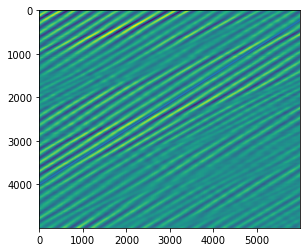

In [10]:
plt.figure()
plt.imshow(working_dat[:,:,0])
plt.plot(np.arange(6000),-np.arange(6000)*0.63 +4000)
plt.show()

In [11]:
u_dot_stlsq = model.predict(working_dat)
u_dot_test = ps.FiniteDifference(axis=1)._differentiate(working_dat, t=1)

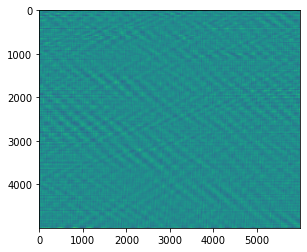

In [12]:
plt.imshow(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0])
plt.show()

In [13]:
np.mean(np.abs(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.23320266)

### Derivative exclude advection

In [14]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,x_dot=u_dot_test-u_dot_stlsq, ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [15]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.01
(x0)' = 22.313 x0_111 + 0.044 x0x0x0_1 + 7.858 x0x0x0_111


### Remove Linear?

In [16]:
thresh = 0.3
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [17]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.3
(x0)' = 0.637 x0_1 + 30.776 x0_111


In [18]:
u_dot_stlsq = model.predict(working_dat)
u_dot_test = ps.FiniteDifference(axis=1)._differentiate(working_dat, t=1)

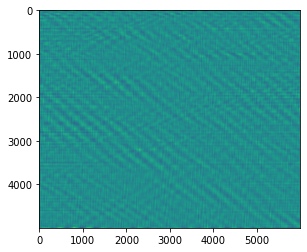

In [19]:
plt.imshow(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0])
plt.show()

In [20]:
np.mean(np.abs(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.20191027)

### Derivative exclude linear

In [23]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,x_dot=u_dot_test-u_dot_stlsq, ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [24]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.011 x0_11 + -0.011 x0x0x0_1 + -0.001 x0x0_11 + -1.755 x0x0x0_111


In [25]:
u_dot_add = model.predict(working_dat)


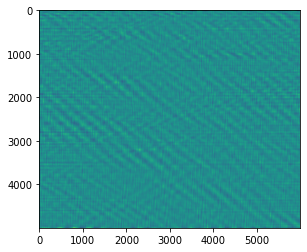

In [26]:
plt.imshow(u_dot_test[:,:,0]-(u_dot_stlsq+u_dot_add)[:,:,0])
plt.show()

In [27]:
np.mean(np.abs(u_dot_test[:,:,0]-(u_dot_stlsq+u_dot_add)[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.2017646)

### Normalized Reflections

In [6]:
thresh = 0.3
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [7]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.3
(x0)' = 0.637 x0_1 + 30.776 x0_111


In [8]:
u_dot_stlsq = model.predict(working_dat)
u_dot_test = SmoothedFiniteDifference(smoother_kws={'window_length': 5},axis=1)._differentiate(working_dat, t=1)

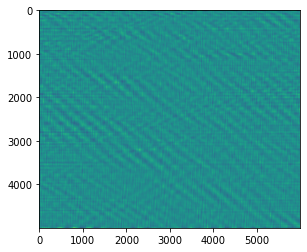

In [9]:
plt.imshow(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0])
plt.show()

In [10]:
np.mean(np.abs(u_dot_test[:,:,0]-u_dot_stlsq[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.20191023)

#### Effect of Third Order

In [12]:
np.mean(np.abs((0.637 *SmoothedFiniteDifference(smoother_kws={'window_length': 5},axis=0)._differentiate(working_dat, t=1))[:,:,0]-u_dot_stlsq[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.13228872)

### Derivative exclude linear

In [10]:
upd_deriv = u_dot_test-u_dot_stlsq
upd_deriv = upd_deriv/np.std(upd_deriv)

In [13]:
thresh = 0.5
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,x_dot=upd_deriv, ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)


In [14]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()

Ensemble STLSQ with Threshold 0.5
(x0)' = 2.237 x0_1 + 12.128 x0_11 + 414.021 x0_111 + -7.755 x0x0x0_1 + -0.237 x0x0_11 + -8.938 x0x0x0_11 + -53.050 x0x0_111 + -1290.576 x0x0x0_111


In [15]:
u_dot_add = model.predict(working_dat)


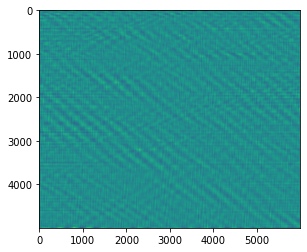

In [16]:
plt.imshow(upd_deriv[:,:,0])
plt.show()

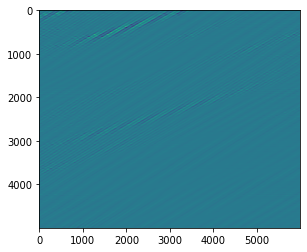

In [17]:
plt.imshow(u_dot_add[:,:,0])
plt.show()

In [27]:
np.mean(np.abs(u_dot_test[:,:,0]-(u_dot_stlsq+u_dot_add)[:,:,0]))/np.mean(np.abs(u_dot_test))

AxesArray(0.2017646)

### Remove simple advecting sine wave

In [5]:
x_fit = working_dat[:,0,0]

In [6]:
def sine_wave(x, frequency, coeff, offset):
    return coeff*np.sin(frequency * x + offset) 

In [7]:
initial_guess = [0.03,1., 0.]

# Fit the data using curve_fit
popt, _ = curve_fit(sine_wave, xs, x_fit, p0=initial_guess)
frequency_fit, coeff_fit, offset_fit = popt

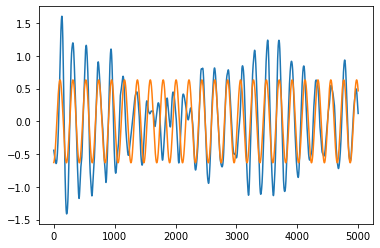

In [8]:
plt.figure()
plt.plot(xs,x_fit)
plt.plot(xs,sine_wave(xs,frequency_fit, coeff_fit, offset_fit))
plt.show()

In [9]:
frequency_fit

0.029664452221317188

In [10]:
bad_approx = np.zeros((5000,6000))

for i in range(6000):
    bad_approx[:,i] = sine_wave(xs,frequency_fit, coeff_fit, offset_fit+0.637*i )


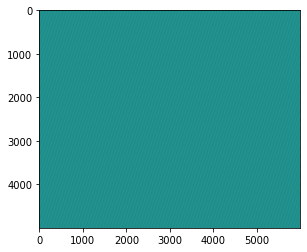

In [11]:
plt.imshow(bad_approx)

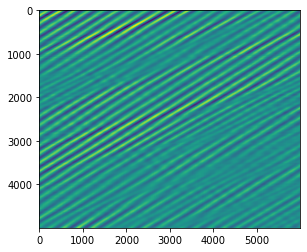

In [12]:
plt.imshow(working_dat)

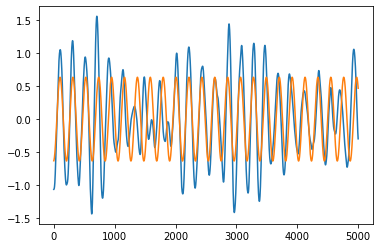

In [13]:
plt.figure()
plt.plot(xs,working_dat[:,1000,0])
plt.plot(xs,sine_wave(xs,frequency_fit, coeff_fit, offset_fit+0.637*0))
plt.show()

In [14]:
frequency_fit

0.029664452221317188

In [15]:
def sine_w_freq(x, coeff, offset):
    return coeff*np.sin(frequency_fit * x + offset) 

In [16]:
coeffs = np.zeros(6000)
offsets = np.zeros(6000)

for i in range(6000):
    initial_guess = [1., 1.+0.64*i]

# Fit the data using curve_fit
    popt, _ = curve_fit(sine_w_freq, xs, working_dat[:,i,0], p0=initial_guess, bounds=(0., np.inf))
    coeffs[i]= popt[0]
    offsets[i]= popt[1]

In [17]:
g = np.zeros((5000,6000))
for i in range(6000):
    g[:,i] = sine_w_freq(xs, coeffs[i], offsets[i])

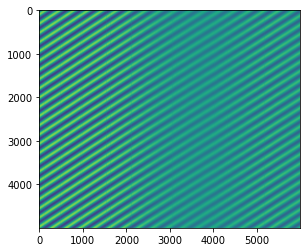

In [18]:
plt.imshow(g,vmin=-1.,vmax=1.)
plt.show()

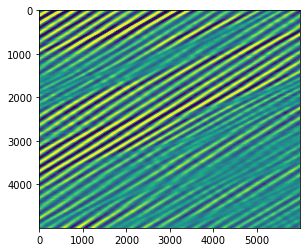

In [19]:
plt.imshow(working_dat,vmin=-1.,vmax=1.)
plt.show()

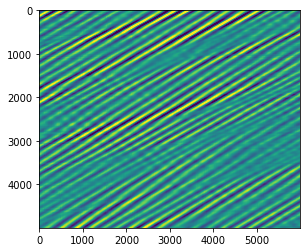

In [21]:
plt.imshow(working_dat[:,:,0]-g,vmin=-1.,vmax=1.)
plt.show()

In [57]:
np.mean(np.abs(working_dat[:,:,0]-g))

0.3570534574433893

In [58]:
np.mean(np.abs(working_dat[:,:,0]))

0.42813799772342237

In [59]:
np.mean(np.abs(g))

0.25654164012915776

In [62]:
rem_1 =working_dat[:,:,0]-g

In [79]:
coeffs = np.zeros(6000)
offsets = np.zeros(6000)

for i in range(6000):
    initial_guess = [0.03,1., 1.+0.64*i]

# Fit the data using curve_fit
    popt, _ = curve_fit(sine_wave, xs, rem_1[:,i], p0=initial_guess, bounds=(0., [1.,8.,1e7]))
    coeffs[i]= popt[0]
    offsets[i]= popt[1]

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

In [ ]:
h = np.zeros((5000,6000))
for i in range(6000):
    h[:,i] = sine_w_freq(xs, coeffs[i], offsets[i])

In [ ]:
plt.imshow(h,vmin=-1.,vmax=1.)
plt.show()

In [ ]:
plt.figure()
plt.plot(xs,rem_1[:,1000])
plt.plot(xs,sine_wave(xs,frequency_fit*1.1, coeff_fit, offset_fit+0.637*20))
plt.show()